In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement =  Base.classes.measurement
Station =  Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session=Session(bind=engine)

# Exploratory Precipitation Analysis

In [10]:
from sqlalchemy import inspect
inspector = inspect(engine)

In [11]:
columns_measurement = inspector.get_columns('measurement')
for column in columns_measurement:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns_station = inspector.get_columns('station')
for column in columns_station:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [14]:
# Calculating the date 1year before from the last date in the data set

one_year_before_date = (dt.datetime.strptime(recent_date[0], '%Y-%m-%d') - dt.timedelta(days=365)).date()
one_year_before_date

datetime.date(2016, 8, 23)

In [15]:
# Query to get the date and precipitation for last 12 months
prcp_results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_before_date).all()


In [16]:
# Saving results in a pandas dataframe and sorting on date

prcp_df = pd.DataFrame(prcp_results, columns = ['Date', 'Precipitation'])
prcp_df = prcp_df.sort_values('Date', ascending=True).reset_index(drop=True)
prcp_df.head(10)

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,NaN
2,2016-08-23,1.79
3,2016-08-23,0.05
4,2016-08-23,0.15
5,2016-08-23,0.70
6,2016-08-23,0.02
7,2016-08-24,0.08
8,2016-08-24,2.15
9,2016-08-24,2.28


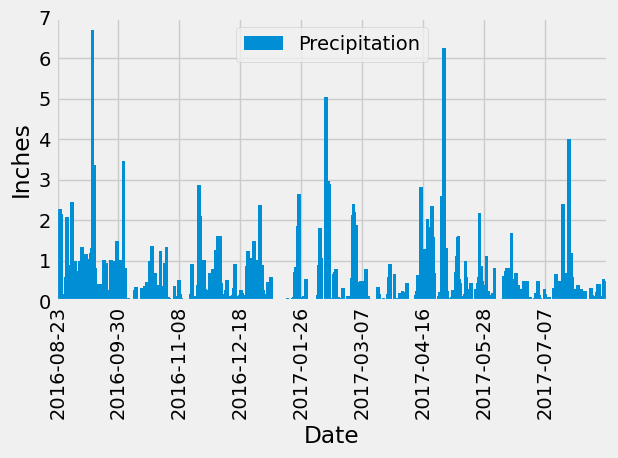

In [17]:
# Plotting data with Pandas and Matplotlib
xtick_pos = np.linspace(0, prcp_df.shape[0]-1, 9, endpoint=False, dtype=int)
xtick_labels = [prcp_df['Date'][i] for i in xtick_pos]
ax = prcp_df.plot.bar('Date', 'Precipitation', ylabel='Inches', width=15, ylim= (0,7), rot=90)
ax.set_xticks(xtick_pos)
ax.set_xticklabels(xtick_labels)
plt.tight_layout()
plt.show()

In [18]:
# Displaying the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.station).count()

9

In [20]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(func.Distinct(Measurement.station))).first()

(9,)

In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                         .group_by(Measurement.station)\
                         .order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

temp_active = session.query(func.Min(Measurement.tobs), func.Max(Measurement.tobs), func.avg(Measurement.tobs))\
       .filter(Measurement.station == active_stations[0][0]).first()
temp_active

(54.0, 85.0, 71.66378066378067)

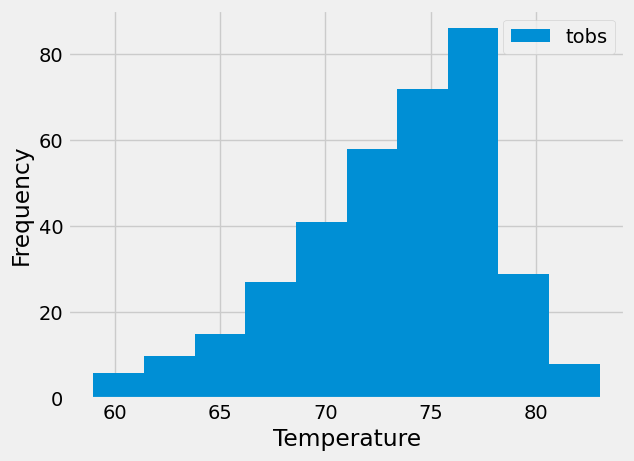

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_results = session.query(Measurement.tobs).filter(Measurement.station == active_stations[0][0], Measurement.date >= one_year_before_date).all()
temp_values =  [temp_results[i][0] for i in range(len(temp_results))]
plt.hist(temp_values, bins=10, label='tobs')
plt.xlabel('Temperature')
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.show()

# Close Session

In [26]:
# Close Session
session.close()